In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.init as init
from torch.distributions import Categorical
from torch.nn import functional as F
import numpy as np
from tqdm import tqdm
import pandas as pd

from model.CustomDataSet import CustomDataSetRNN
from model.Tokenizer import SimpleTokenizerV1
from environnement.environnement1Str import Environnement1
from environnement.environnement3Str import Environnement3
from environnement.environnement6Str import Environnement6
from environnement.small_loop import small_loop
from environnement.gridWorld import gridWorld
from model.RNN import LSTM_GenText

from outil import *

In [2]:
# Create data
env_test = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))
actions, outcomes = [], []

inter_test = []
for i in range(1000):
    action = str(np.random.choice(env_test.get_actions()))
    outcome = env_test.outcome(action)
    actions.append(action)
    outcomes.append(outcome)
    inter_test.append((action, outcome))
    
for i in inter_test:
    print(i)

The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 1 1 1 1 1]]
('turn_left', 'empty')
('forward', 'wall')
('feel_front', 'wall')
('forward', 'wall')
('turn_left', 'empty')
('feel_front', 'empty')
('feel_left', 'empty')
('turn_right', 'empty')
('feel_right', 'wall')
('feel_left', 'empty')
('feel_front', 'wall')
('turn_right', 'empty')
('feel_left', 'wall')
('feel_right', 'empty')
('feel_right', 'empty')
('forward', 'wall')
('feel_right', 'empty')
('turn_right', 'empty')
('feel_left', 'wall')
('turn_left', 'empty')
('turn_left', 'empty')
('feel_right', 'wall')
('feel_right', 'wall')
('turn_left', 'empty')
('forward', 'empty')
('feel_left', 'empty')
('forward', 'empty')
('feel_front', 'empty')
('forward', 'empty')
('feel_front', 'wall')
('feel_right', 'wall')
('forward', 'wall')
('feel_left', 'empty')
('feel_left', 'empty')
('forward', 'wall')
('forward', 'wall')
('forward', 'wall')
('feel_front', 'wall')
('forward', 'wall

In [3]:
# Create vocab
list_vocab = ['<pad>', '<eos>', '<unk>']
for act in env_test.get_actions():
    for fb in env_test.get_outcomes():
        list_vocab.append((act, fb))
for element in list_vocab:
    print(element)
    
tmp = create_dico_numerate_word(list_vocab)
print(tmp)

tokenizer = SimpleTokenizerV1(vocab=
        create_dico_numerate_word(tmp))
print(tokenizer.encode(("forward", "empty")))
print(tokenizer.encode("<pad>"))


<pad>
<eos>
<unk>
('forward', 'wall')
('forward', 'empty')
('turn_left', 'wall')
('turn_left', 'empty')
('turn_right', 'wall')
('turn_right', 'empty')
('feel_front', 'wall')
('feel_front', 'empty')
('feel_left', 'wall')
('feel_left', 'empty')
('feel_right', 'wall')
('feel_right', 'empty')
{'<pad>': 0, '<eos>': 1, '<unk>': 2, ('forward', 'wall'): 3, ('forward', 'empty'): 4, ('turn_left', 'wall'): 5, ('turn_left', 'empty'): 6, ('turn_right', 'wall'): 7, ('turn_right', 'empty'): 8, ('feel_front', 'wall'): 9, ('feel_front', 'empty'): 10, ('feel_left', 'wall'): 11, ('feel_left', 'empty'): 12, ('feel_right', 'wall'): 13, ('feel_right', 'empty'): 14}
4
0


In [4]:
# Model
num_layers = 2
hidden_size = 128
temp = 1.0
lstm_generator = LSTM_GenText(
    num_emb=len(list_vocab),
    hidden_size=hidden_size,
    emb_size=hidden_size,
    num_layers=num_layers,
    dropout=0.1
)
input_tokens = [tokenizer.encode((actions[i], outcomes[i])) for i in range(len(actions))]
print("prompt :")
for i in input_tokens:
    print(tokenizer.decode(i))
input_tokens = torch.tensor(input_tokens).reshape(1, -1)
lstm_generator.eval()
log_tokens = []
# Disable gradient calculation
with torch.no_grad():    
    # Initialize hidden and memory states
    hidden = torch.zeros(num_layers, 1, hidden_size)
    memory = torch.zeros(num_layers, 1, hidden_size)
    
    # Generate text
    for i in range(100):
        # Forward pass through LSTM generator
        data_pred, hidden, memory = lstm_generator(input_tokens, hidden, memory)
        
        # Sample from the distribution of probabilities (with temperature)
        dist = Categorical(logits=data_pred[:, -1] / temp)
        input_tokens = dist.sample().reshape(1, 1)
        
        # Append generated token to log_tokens
        log_tokens.append(input_tokens.cpu())
        
        # Check for end-of-sentence token
        if input_tokens.item() == 2:
            break
        
print("output :")
for i in log_tokens:
    print(tokenizer.decode(i.item()))



prompt :
('turn_left', 'empty')
('forward', 'wall')
('feel_front', 'wall')
('forward', 'wall')
('turn_left', 'empty')
('feel_front', 'empty')
('feel_left', 'empty')
('turn_right', 'empty')
('feel_right', 'wall')
('feel_left', 'empty')
('feel_front', 'wall')
('turn_right', 'empty')
('feel_left', 'wall')
('feel_right', 'empty')
('feel_right', 'empty')
('forward', 'wall')
('feel_right', 'empty')
('turn_right', 'empty')
('feel_left', 'wall')
('turn_left', 'empty')
('turn_left', 'empty')
('feel_right', 'wall')
('feel_right', 'wall')
('turn_left', 'empty')
('forward', 'empty')
('feel_left', 'empty')
('forward', 'empty')
('feel_front', 'empty')
('forward', 'empty')
('feel_front', 'wall')
('feel_right', 'wall')
('forward', 'wall')
('feel_left', 'empty')
('feel_left', 'empty')
('forward', 'wall')
('forward', 'wall')
('forward', 'wall')
('feel_front', 'wall')
('forward', 'wall')
('turn_left', 'empty')
('feel_front', 'empty')
('turn_left', 'empty')
('turn_left', 'empty')
('feel_left', 'wall')
('f

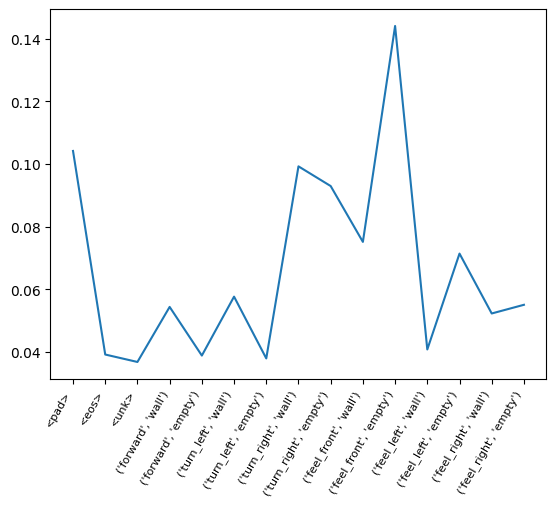

In [15]:
# Plot the distribution of probabilities
# write in absice the action and the feedback
plt.xticks(range(len(list_vocab)), list_vocab, fontsize=8, rotation=60, ha='right')
plt.plot(F.softmax(data_pred/temp, -1).cpu().numpy().flatten())

In [6]:
input_tokens = [tokenizer.encode(i) for i in inter_test]
print("prompt :")
for i in input_tokens:
    print(tokenizer.decode(i))
    print(i)

prompt :
('turn_left', 'empty')
6
('forward', 'wall')
3
('feel_front', 'wall')
9
('forward', 'wall')
3
('turn_left', 'empty')
6
('feel_front', 'empty')
10
('feel_left', 'empty')
12
('turn_right', 'empty')
8
('feel_right', 'wall')
13
('feel_left', 'empty')
12
('feel_front', 'wall')
9
('turn_right', 'empty')
8
('feel_left', 'wall')
11
('feel_right', 'empty')
14
('feel_right', 'empty')
14
('forward', 'wall')
3
('feel_right', 'empty')
14
('turn_right', 'empty')
8
('feel_left', 'wall')
11
('turn_left', 'empty')
6
('turn_left', 'empty')
6
('feel_right', 'wall')
13
('feel_right', 'wall')
13
('turn_left', 'empty')
6
('forward', 'empty')
4
('feel_left', 'empty')
12
('forward', 'empty')
4
('feel_front', 'empty')
10
('forward', 'empty')
4
('feel_front', 'wall')
9
('feel_right', 'wall')
13
('forward', 'wall')
3
('feel_left', 'empty')
12
('feel_left', 'empty')
12
('forward', 'wall')
3
('forward', 'wall')
3
('forward', 'wall')
3
('feel_front', 'wall')
9
('forward', 'wall')
3
('turn_left', 'empty')
6

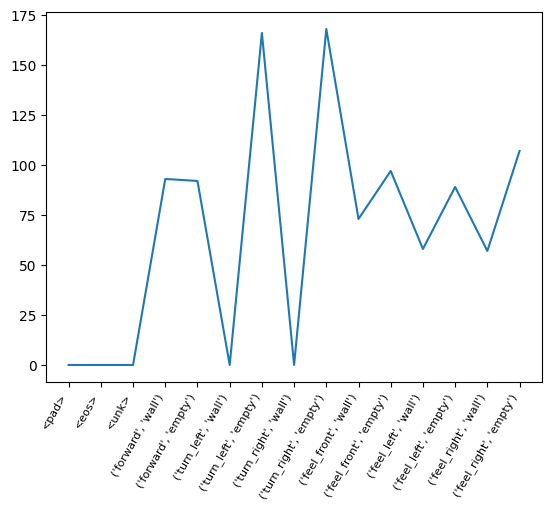

In [7]:
# Count each token
def count_inter(tokens, list_vocab):
    count = {}
    for i in tokens:
        if i in count:
            count[i] += 1
        else:
            count[i] = 1
    values_count = []

    for i in range(len(list_vocab)):
        if i in count:
            values_count.append(count[i])
        else:
            values_count.append(0)
    plt.xticks(range(len(list_vocab)), list_vocab, fontsize=8, rotation=60, ha='right')
    plt.plot(values_count)
    
count_inter(input_tokens, list_vocab)

4
[[4], [12, 4], [10, 4], [9, 13, 3, 12, 12, 3, 3, 3, 9, 3, 6, 10, 6, 6, 11, 14, 8, 10, 4], [10, 8, 10, 10, 12, 12, 6, 4, 4], [6, 3, 3, 13, 13, 3, 12, 12, 9, 8, 8, 10, 6, 14, 11, 3, 3, 11, 11, 8, 4], [14, 8, 10, 8, 6, 14, 6, 4], [8, 8, 13, 6, 14, 12, 4], [10, 6, 14, 4], [6, 10, 12, 6, 14, 6, 10, 14, 4], [8, 10, 6, 8, 10, 14, 8, 6, 6, 4], [11, 8, 11, 11, 10, 8, 8, 3, 6, 8, 13, 13, 6, 4], [8, 8, 4], [8, 4], [10, 4, 4], [8, 8, 4], [8, 3, 3, 8, 10, 10, 4], [14, 8, 4], [14, 11, 10, 8, 10, 12, 8, 8, 3, 8, 10, 4], [6, 8, 8, 12, 6, 4], [3, 3, 6, 12, 8, 9, 9, 6, 3, 9, 6, 10, 4], [12, 12, 4], [10, 13, 4], [8, 9, 3, 3, 9, 8, 10, 8, 4], [8, 14, 12, 8, 4], [6, 9, 12, 13, 8, 8, 14, 6, 9, 11, 14, 9, 14, 9, 11, 9, 3, 11, 11, 6, 3, 8, 11, 11, 3, 8, 10, 8, 4, 4], [8, 8, 11, 14, 11, 11, 11, 11, 11, 11, 8, 8, 8, 6, 8, 14, 14, 14, 6, 10, 12, 12, 8, 14, 12, 14, 6, 10, 4], [3, 9, 8, 9, 9, 8, 8, 13, 13, 13, 10, 6, 14, 11, 6, 11, 8, 6, 9, 8, 8, 8, 8, 3, 11, 14, 9, 14, 6, 12, 3, 3, 9, 9, 9, 12, 13, 12, 13, 3, 6

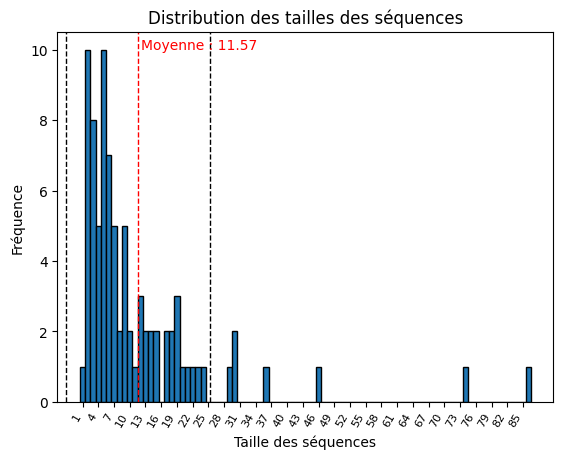

In [8]:
# find all sequence between two token
def find_sequence(token, sequence):
    res = []
    sentence = []
    find_end = False
    for i in range(0, len(sequence) -1 ):
        if not(find_end) and sequence[i] == token:
            find_end = True
        if find_end :
            if sequence[i] == token and sequence[i +1] != token:
                res.append(sentence + [token])
                sentence = []
            else:
                sentence.append(sequence[i])
            
    return res

print(tokenizer.encode(("forward", "empty")))
sequences = find_sequence(tokenizer.encode(("forward", "empty")), input_tokens)
print(sequences)

# Stocker les tailles des séquences
sequence_lengths = [len(seq) for seq in sequences]

# Visualiser les tailles des séquences avec un histogramme
plt.close()
plt.hist(sequence_lengths, bins=range(min(sequence_lengths), max(sequence_lengths) + 2), align='left', edgecolor='black')
# Means of the sequence
plt.axvline(np.mean(sequence_lengths), color='red', linestyle='dashed', linewidth=1)
plt.axvline(np.std(sequence_lengths) + np.mean(sequence_lengths), color='black', linestyle='dashed', linewidth=1)
plt.axvline(-np.std(sequence_lengths) + np.mean(sequence_lengths), color='black', linestyle='dashed', linewidth=1)

plt.text(np.mean(sequence_lengths) + 0.5, 10, 'Moyenne : {:.2f}'.format(np.mean(sequence_lengths)), color='red')
plt.xticks(range(min(sequence_lengths), max(sequence_lengths) + 1, 3), fontsize=8, rotation=60, ha='right')
plt.xlabel('Taille des séquences')
plt.ylabel('Fréquence')
plt.title('Distribution des tailles des séquences')
plt.show()
plt.close()

# Stocker les tailles des séquences et les séquence dans un pandas DataFrame
sequences_decode = [tokenizer.decode(seq) for seq in sequences]
df = pd.DataFrame({'taille': sequence_lengths, 'sequence': sequences_decode})
 



4
[[4, 4, 4], [9, 13, 9, 6, 4], [9, 8, 4], [3, 9, 6, 4, 4], [12, 3, 9, 6, 4], [3, 11, 3, 9, 6, 3, 9, 8, 3, 14, 3, 11, 9, 11, 11, 14, 3, 9, 11, 6, 3, 6, 4], [3, 8, 4], [11, 8, 3, 6, 4], [14, 3, 6, 3, 9, 12, 6, 4], [6, 3, 8, 4], [8, 3, 8, 4], [13, 11, 13, 13, 6, 3, 8, 4], [14, 9, 6, 3, 8, 3, 14, 11, 14, 14, 3, 14, 6, 3, 8, 9, 8, 11, 8, 13, 8, 3, 6, 10, 4, 4], [3, 6, 10, 4], [3, 6, 3, 6, 10, 4], [6, 12, 3, 12, 6, 4], [6, 13, 8, 6, 3, 6, 10, 4], [11, 14, 8, 4], [8, 8, 4], [6, 6, 4], [8, 8, 4], [6, 8, 3, 6, 10, 4], [3, 11, 14, 8, 4], [6, 6, 4], [6, 12, 8, 3, 6, 10, 10, 4], [9, 6, 9, 6, 10, 12, 4], [9, 9, 11, 6, 6, 4], [3, 9, 6, 9, 6, 6, 4], [11, 13, 6, 6, 4], [12, 6, 4], [14, 8, 4], [13, 10, 13, 13, 6, 6, 4], [13, 9, 6, 6, 4], [10, 4], [13, 6, 6, 4], [10, 4], [6, 6, 4], [10, 4], [6, 6, 4], [10, 4], [6, 6, 4], [10, 4], [6, 6, 4], [10, 4], [6, 6, 4], [10, 4], [6, 6, 4], [10, 4], [6, 6, 4], [10, 4], [6, 6, 4], [10, 4], [6, 6, 4], [10, 4], [6, 6, 4], [10, 4], [6, 6, 4], [10, 4], [6, 6, 4], [10,

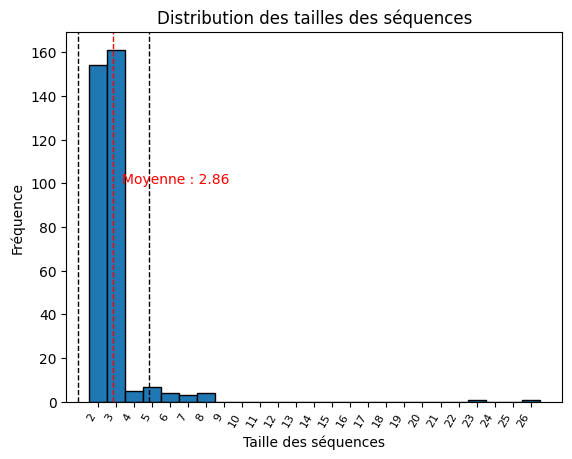

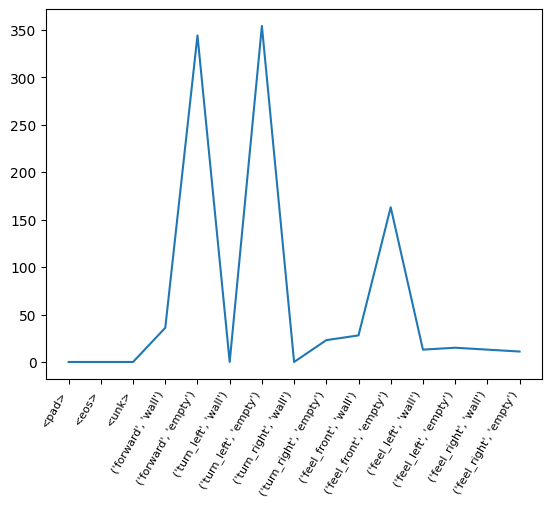

In [9]:
# find all sequence between two token
def find_sequence(token, sequence):
    res = []
    sentence = []
    find_end = False
    for i in range(0, len(sequence) -1 ):
        if not(find_end) and sequence[i] == token:
            find_end = True
        if find_end :
            if sequence[i] == token and sequence[i +1] != token:
                res.append(sentence + [token])
                sentence = []
            else:
                sentence.append(sequence[i])
            
    return res

# Load data
actions = np.load('overfit_action.npy')
outcomes = np.load('overfit_feedback.npy')

token_overfit = []
for i in range(len(actions) - 1):
    token_overfit.append(tokenizer.encode((actions[i], outcomes[i])))

print(tokenizer.encode(("forward", "empty")))
sequences = find_sequence(tokenizer.encode(("forward", "empty")), token_overfit)
print(sequences)

# Stocker les tailles des séquences
sequence_lengths = [len(seq) for seq in sequences]

# Visualiser les tailles des séquences avec un histogramme
plt.hist(sequence_lengths, bins=range(min(sequence_lengths), max(sequence_lengths) + 2), align='left', edgecolor='black')
# Means of the sequence
plt.axvline(np.mean(sequence_lengths), color='red', linestyle='dashed', linewidth=1)
plt.axvline(np.std(sequence_lengths) + np.mean(sequence_lengths), color='black', linestyle='dashed', linewidth=1)
plt.axvline(-np.std(sequence_lengths) + np.mean(sequence_lengths), color='black', linestyle='dashed', linewidth=1)

plt.text(np.mean(sequence_lengths) + 0.5, 100, 'Moyenne : {:.2f}'.format(np.mean(sequence_lengths)), color='red')
plt.xticks(range(min(sequence_lengths), max(sequence_lengths) + 1, 1), fontsize=8, rotation=60, ha='right')
plt.xlabel('Taille des séquences')
plt.ylabel('Fréquence')
plt.title('Distribution des tailles des séquences')
plt.show()

# Stocker les tailles des séquences et les séquence dans un pandas DataFrame
sequences_decode = [tokenizer.decode(seq) for seq in sequences]
df_overfit = pd.DataFrame({'taille': sequence_lengths, 'sequence': sequences_decode})
 
count_inter(token_overfit, list_vocab)



4
[[4, 4, 4], [9, 13, 8, 3, 6, 3, 8, 3, 8, 10, 4], [11, 4, 4], [3, 14, 3, 14, 9, 14, 11, 3, 14, 14, 3, 11, 3, 11, 9, 14, 6, 3, 13, 6, 4, 4], [13, 6, 3, 8, 10, 4], [12, 13, 8, 9, 14, 8, 4, 4], [13, 4], [3, 3, 8, 10, 4], [6, 3, 8, 10, 4], [8, 4], [3, 13, 6, 4], [3, 8, 9, 14, 8, 4], [8, 4], [8, 3, 8, 10, 4], [13, 3, 8, 9, 3, 9, 6, 3, 8, 9, 8, 4], [13, 13, 9, 8, 3, 8, 10, 4], [12, 6, 4], [3, 11, 11, 13, 13, 11, 6, 3, 8, 9, 6, 9, 13, 12, 6, 4], [11, 3, 14, 8, 4], [6, 12, 4], [13, 11, 8, 3, 12, 6, 4], [6, 13, 12, 6, 4], [8, 12, 3, 12, 6, 4], [8, 14, 4], [6, 12, 4], [6, 6, 4], [6, 12, 3, 12, 6, 4], [6, 8, 3, 11, 6, 6, 4], [8, 6, 3, 11, 6, 6, 4], [8, 8, 4], [8, 8, 4], [11, 13, 11, 9, 11, 6, 6, 4], [9, 11, 8, 11, 10, 4], [12, 8, 3, 11, 8, 11, 4], [3, 8, 9, 11, 9, 9, 11, 9, 14, 8, 4], [12, 6, 4], [8, 14, 3, 8, 10, 10, 4], [11, 9, 14, 8, 4], [12, 6, 4], [8, 3, 8, 10, 11, 10, 4], [11, 8, 11, 4], [13, 12, 6, 4], [13, 4], [9, 6, 6, 4], [13, 4], [14, 8, 4], [13, 3, 8, 9, 14, 8, 4], [12, 6, 4], [13, 4

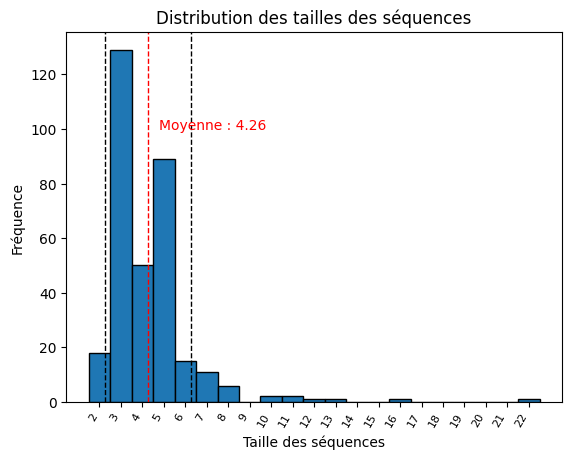

total token :  1500
total token overfit :  1000


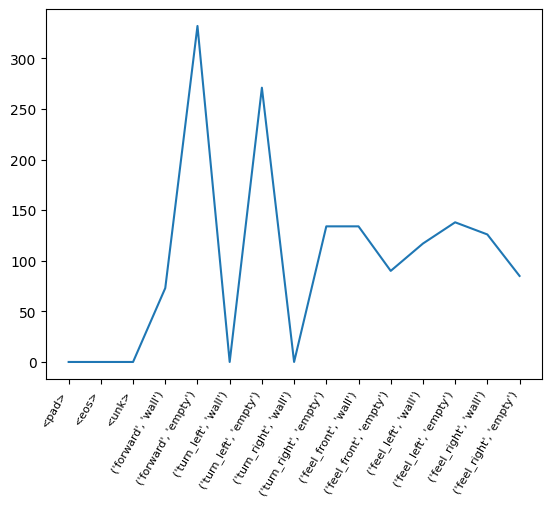

In [10]:
# find all sequence between two token
def find_sequence(token, sequence):
    res = []
    sentence = []
    find_end = False
    for i in range(0, len(sequence) -1 ):
        if not(find_end) and sequence[i] == token:
            find_end = True
        if find_end :
            if sequence[i] == token and sequence[i +1] != token:
                res.append(sentence + [token])
                sentence = []
            else:
                sentence.append(sequence[i])
            
    return res

# Load data
actions = np.load('action.npy')
outcomes = np.load('feedback.npy')

token = []
for i in range(len(actions) - 1):
    token.append(tokenizer.encode((actions[i], outcomes[i])))

print(tokenizer.encode(("forward", "empty")))
sequences = find_sequence(tokenizer.encode(("forward", "empty")), token)
print(sequences)

# Stocker les tailles des séquences
sequence_lengths = [len(seq) for seq in sequences]

# Visualiser les tailles des séquences avec un histogramme
plt.hist(sequence_lengths, bins=range(min(sequence_lengths), max(sequence_lengths) + 2), align='left', edgecolor='black')
# Means of the sequence
plt.axvline(np.mean(sequence_lengths), color='red', linestyle='dashed', linewidth=1)
plt.axvline(np.std(sequence_lengths) + np.mean(sequence_lengths), color='black', linestyle='dashed', linewidth=1)
plt.axvline(-np.std(sequence_lengths) + np.mean(sequence_lengths), color='black', linestyle='dashed', linewidth=1)

plt.text(np.mean(sequence_lengths) + 0.5, 100, 'Moyenne : {:.2f}'.format(np.mean(sequence_lengths)), color='red')
plt.xticks(range(min(sequence_lengths), max(sequence_lengths) + 1, 1), fontsize=8, rotation=60, ha='right')
plt.xlabel('Taille des séquences')
plt.ylabel('Fréquence')
plt.title('Distribution des tailles des séquences')
plt.show()

# Stocker les tailles des séquences et les séquence dans un pandas DataFrame
sequences_decode = [tokenizer.decode(seq) for seq in sequences]
df_overfit = pd.DataFrame({'taille': sequence_lengths, 'sequence': sequences_decode})
 
count_inter(token, list_vocab)
print("total token : ", len(token))
print("total token overfit : ", len(token_overfit))

# No Data

In [11]:
from torch.utils.data import Dataset
import torch.nn.functional as F
class CustomDataSetTextGen(Dataset):
    def __init__(self, actions:list, outcomes:list, context_lenght:int, end_token, tokenizer):
        """
        Creates a custom dataset

        :param actions: list of actions
        :param outcomes: list of outcomes
        :param context_lenght: the length of the context
        :param tokenizer: tokenizer to encode the actions and outcomes
        """
        # Je ne suis pas sur d'y garder
        # assert context_lenght % 2 != 0, "context_lenght must be odd"
        assert len(actions) == len(outcomes), "actions and outcomes must have the same length"
        assert context_lenght > 0, "context_lenght can't be negative or zero"

        self.context_lenght = context_lenght
        self.tokenizer = tokenizer
        self.dim_out = tokenizer.size_vocab
        self.end_token = end_token
        self.data = self.create_data(actions, outcomes)

    def create_data(self, actions, outcomes):
        """
        Create the data
        """
        x = []
        counter = 0
        sentence = []
        for i in range(len(actions) - 1):
            if counter >= self.context_lenght:
                x.append(sentence)
                sentence = []
                counter = 0
            token = self.tokenizer.encode((actions[i], outcomes[i]))
            futur_token = self.tokenizer.encode((actions[i + 1], outcomes[i + 1]))
            sentence.append(token)
            counter += 1
            if token == self.end_token and futur_token != self.end_token:
                for _ in range(self.context_lenght - counter):
                    sentence.append(self.tokenizer.encode("<pad>"))
                x.append(sentence)
                sentence = []
                counter = 0
        return x

    def __len__(self):
        """
        Get the length of the dataset
        :return: length
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Get the item at the index idx

        :param idx: index
        :return: x
        """
        return torch.tensor(self.data[idx])
    
class CustomDataSetTextGenByToken(Dataset):
    def __init__(self, token, context_lenght:int):
        """
        Creates a custom dataset
        """
        # Je ne suis pas sur d'y garder
        # assert context_lenght % 2 != 0, "context_lenght must be odd"
        # assert len(actions) == len(outcomes), "actions and outcomes must have the same length"
        assert context_lenght > 0, "context_lenght can't be negative or zero"

        self.context_lenght = context_lenght
        self.tokenizer = tokenizer
        self.dim_out = tokenizer.size_vocab
        self.token = token
        self.data = self.create_data(actions, outcomes)

    def create_data(self):
        """
        Create the data
        """
        sentences = []
        for range_cut in range(1, len(self.token) +1):
            for i in range(0, len(self.token) +1 - range_cut, 1):
                sentences.append(self.token[i:i + range_cut])
        return sentences

    def __len__(self):
        """
        Get the length of the dataset
        :return: length
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Get the item at the index idx

        :param idx: index
        :return: x
        """
        return torch.tensor(self.data[idx])

In [12]:
num_layers = 2
hidden_size = 128
temp = 1.0
lstm_generator = LSTM_GenText(
    num_emb=len(list_vocab),
    hidden_size=hidden_size,
    emb_size=hidden_size,
    num_layers=num_layers,
    dropout=0.1
)

In [13]:
# Model

# 41
# input_tokens = tokenizer.encode([('feel_front', 'wall')])
# input_tokens = tokenizer.encode([('forward', 'wall')])
# input_tokens = tokenizer.encode([('feel_left', 'wall')])
input_tokens = tokenizer.encode([('feel_left', 'wall'), ('feel_right', 'wall'), ('feel_front', 'wall')])

print("prompt :")
for i in input_tokens:
    print(tokenizer.decode(i))
input_tokens = torch.tensor(input_tokens).reshape(1, -1)
lstm_generator.eval()
log_tokens = []
# Disable gradient calculation
with torch.no_grad():    
    # Initialize hidden and memory states
    hidden = torch.zeros(num_layers, 1, hidden_size)
    memory = torch.zeros(num_layers, 1, hidden_size)
    
    # Generate text
    for i in range(100):
        # Forward pass through LSTM generator
        data_pred, hidden, memory = lstm_generator(input_tokens, hidden, memory)
        
        # Sample from the distribution of probabilities (with temperature)
        dist = Categorical(logits=data_pred[:, -1] / temp)
        input_tokens = dist.sample().reshape(1, 1)
        
        # Append generated token to log_tokens
        log_tokens.append(input_tokens.cpu())
        
        # Check for end-of-sentence token
        if input_tokens.item() == tokenizer.encode(("forward", "empty")):
            break
        
print("output :")
for i in log_tokens:
    print(tokenizer.decode(i.item()))



prompt :
('feel_left', 'wall')
('feel_right', 'wall')
('feel_front', 'wall')
output :
<eos>
('turn_left', 'wall')
('feel_front', 'wall')
('turn_right', 'wall')
('feel_front', 'empty')
('feel_front', 'empty')
('feel_front', 'empty')
<unk>
('feel_right', 'empty')
('turn_left', 'wall')
('feel_front', 'empty')
<unk>
<eos>
('forward', 'wall')
<pad>
('turn_left', 'empty')
('feel_right', 'empty')
('feel_left', 'empty')
('feel_front', 'empty')
('feel_right', 'empty')
('turn_right', 'wall')
('feel_left', 'empty')
('feel_left', 'wall')
('turn_right', 'wall')
('feel_left', 'empty')
('feel_left', 'empty')
('feel_front', 'empty')
<pad>
('forward', 'empty')


In [14]:
envi = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))
action_manuel = []
outcome_manuel = []
assert False, "stop"

The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 1 1 1 1 1]]


AssertionError: stop

# Use texte generate

In [ ]:
token = log_tokens

In [ ]:
token += log_tokens

In [ ]:
def run_token(token:torch.Tensor, env):
    actions = []
    outcomes = []
    for tok in token:
        inter = tokenizer.decode(tok.item())
        if inter in ["<pad>", "<eos>", "<unk>"]:
            continue
        actions.append(inter[0])
        outcomes.append(env.outcome(actions[-1]))
    return actions, outcomes

act, out = run_token(token, envi)
print(act)
print(out)

['feel_left', 'turn_left', 'turn_left', 'forward', 'feel_front', 'feel_left', 'turn_right', 'turn_right', 'turn_left', 'feel_left', 'turn_left', 'feel_left', 'forward']
['wall', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty']


In [ ]:
print(act)
print(len(act))
test_loader = CustomDataSetTextGen(
        actions=act,
        outcomes=out,
        context_lenght=5,
        end_token=tokenizer.encode(('forward', 'empty')),
        tokenizer=tokenizer
    )
print("prompt :")
print(test_loader.data)
sentence:torch.Tensor = None
for sentence in test_loader:
    print(tokenizer.decode(sentence.tolist()))

['turn_right', 'feel_right', 'feel_right', 'turn_left', 'forward', 'feel_right', 'forward', 'feel_left', 'feel_front', 'feel_left', 'feel_front', 'feel_front', 'turn_left', 'feel_right', 'forward']
15
prompt :
[[8, 14, 14, 6, 3], [13, 3, 12, 9, 12]]
[('turn_right', 'empty'), ('feel_right', 'empty'), ('feel_right', 'empty'), ('turn_left', 'empty'), ('forward', 'wall')]
[('feel_right', 'wall'), ('forward', 'wall'), ('feel_left', 'empty'), ('feel_front', 'wall'), ('feel_left', 'empty')]


In [ ]:
def action_outcome_to_token(actions, outcomes):
    token = []
    for i in range(len(actions)):
        token.append(tokenizer.encode((actions[i], outcomes[i])))
    return token

tokens = action_outcome_to_token(act, out)
print(tokens)

data_set = CustomDataSetTextGenByToken(tokens, 3)

[[11],
 [6],
 [6],
 [4],
 [10],
 [12],
 [8],
 [8],
 [6],
 [12],
 [6],
 [12],
 [4],
 [11, 6],
 [6, 6],
 [6, 4],
 [4, 10],
 [10, 12],
 [12, 8],
 [8, 8],
 [8, 6],
 [6, 12],
 [12, 6],
 [6, 12],
 [12, 4],
 [11, 6, 6],
 [6, 6, 4],
 [6, 4, 10],
 [4, 10, 12],
 [10, 12, 8],
 [12, 8, 8],
 [8, 8, 6],
 [8, 6, 12],
 [6, 12, 6],
 [12, 6, 12],
 [6, 12, 4],
 [11, 6, 6, 4],
 [6, 6, 4, 10],
 [6, 4, 10, 12],
 [4, 10, 12, 8],
 [10, 12, 8, 8],
 [12, 8, 8, 6],
 [8, 8, 6, 12],
 [8, 6, 12, 6],
 [6, 12, 6, 12],
 [12, 6, 12, 4],
 [11, 6, 6, 4, 10],
 [6, 6, 4, 10, 12],
 [6, 4, 10, 12, 8],
 [4, 10, 12, 8, 8],
 [10, 12, 8, 8, 6],
 [12, 8, 8, 6, 12],
 [8, 8, 6, 12, 6],
 [8, 6, 12, 6, 12],
 [6, 12, 6, 12, 4],
 [11, 6, 6, 4, 10, 12],
 [6, 6, 4, 10, 12, 8],
 [6, 4, 10, 12, 8, 8],
 [4, 10, 12, 8, 8, 6],
 [10, 12, 8, 8, 6, 12],
 [12, 8, 8, 6, 12, 6],
 [8, 8, 6, 12, 6, 12],
 [8, 6, 12, 6, 12, 4],
 [11, 6, 6, 4, 10, 12, 8],
 [6, 6, 4, 10, 12, 8, 8],
 [6, 4, 10, 12, 8, 8, 6],
 [4, 10, 12, 8, 8, 6, 12],
 [10, 12, 8, 8, 6, 1

# Make manualy data

In [ ]:
action_manuel.append("forward")
outcome_manuel.append(envi.outcome("forward"))
print(outcome_manuel[-1])

empty


In [ ]:
action_manuel.append("feel_front")
outcome_manuel.append(envi.outcome("feel_front"))
print(outcome_manuel[-1])

wall


In [ ]:
action_manuel.append("feel_right")
outcome_manuel.append(envi.outcome("feel_right"))
print(outcome_manuel[-1])

wall


In [ ]:
action_manuel.append("feel_left")
outcome_manuel.append(envi.outcome("feel_left"))
print(outcome_manuel[-1])

empty


In [ ]:
action_manuel.append("turn_left")
outcome_manuel.append(envi.outcome("turn_left"))
print(outcome_manuel[-1])

empty


In [ ]:
action_manuel.append("turn_right")
outcome_manuel.append(envi.outcome("turn_right"))
print(outcome_manuel[-1])

empty


In [ ]:
print(action_manuel)
print(len(action_manuel))
test_loader = CustomDataSetTextGen(
        actions=action_manuel,
        outcomes=outcome_manuel,
        context_lenght=5,
        end_token=tokenizer.encode(('forward', 'empty')),
        tokenizer=tokenizer
    )
print("prompt :")
print(test_loader.data)
sentence:torch.Tensor = None
for sentence in test_loader:
    print(tokenizer.decode(sentence.tolist()))

['turn_right', 'turn_right', 'feel_left', 'turn_right', 'feel_right', 'feel_front', 'turn_left', 'feel_left', 'turn_right', 'turn_right', 'turn_right', 'turn_right']
12
prompt :
[[8, 8, 12, 8, 13], [9, 6, 12, 8, 8]]
[('turn_right', 'empty'), ('turn_right', 'empty'), ('feel_left', 'empty'), ('turn_right', 'empty'), ('feel_right', 'wall')]
[('feel_front', 'wall'), ('turn_left', 'empty'), ('feel_left', 'empty'), ('turn_right', 'empty'), ('turn_right', 'empty')]


# Use "good" train data

# Use rand action

In [ ]:
actions, outcomes = [], []
for i in range(1000):
    action = str(np.random.choice(env_test.get_actions()))
    outcome = env_test.outcome(action)
    actions.append(action)
    outcomes.append(outcome)
    
test_loader = CustomDataSetTextGen(
        actions=actions,
        outcomes=outcomes,
        context_lenght=20,
        end_token=tokenizer.encode(('forward', 'empty')),
        tokenizer=tokenizer
    )
print("data len : ", test_loader.__len__())
sentence:torch.Tensor = None
for sentence in test_loader:
    print(tokenizer.decode(sentence.tolist()))

data len :  97
[('turn_left', 'empty'), ('feel_front', 'empty'), ('forward', 'empty'), ('forward', 'empty'), '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
[('feel_left', 'empty'), ('feel_right', 'empty'), ('turn_left', 'empty'), ('feel_right', 'wall'), ('turn_left', 'empty'), ('feel_left', 'empty'), ('turn_right', 'empty'), ('feel_front', 'empty'), ('feel_left', 'empty'), ('feel_front', 'empty'), ('feel_front', 'empty'), ('feel_left', 'empty'), ('turn_left', 'empty'), ('turn_left', 'empty'), ('turn_right', 'empty'), ('feel_left', 'empty'), ('feel_right', 'empty'), ('forward', 'empty'), '<pad>', '<pad>']
[('turn_right', 'empty'), ('forward', 'empty'), ('forward', 'empty'), '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
[('turn_left', 'empty'), ('feel_left', 'empty'), ('turn_left', 'empt

# Train

In [ ]:
data_loader_train = DataLoader(
    test_loader,
    batch_size=1,
    shuffle=True,
    num_workers=8
)

In [ ]:
optimizer = optim.Adam(lstm_generator.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Training

100%|██████████| 50/50 [00:07<00:00,  6.63it/s]


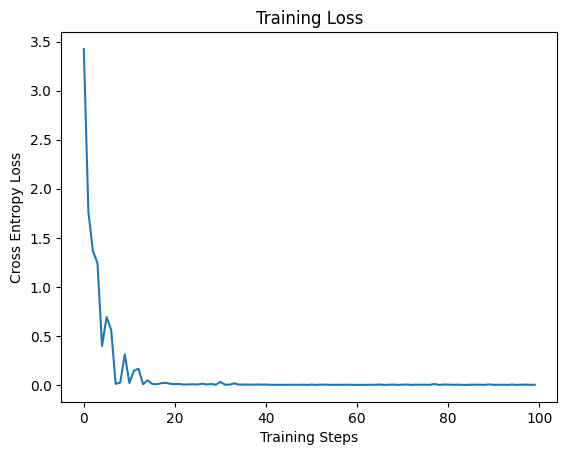

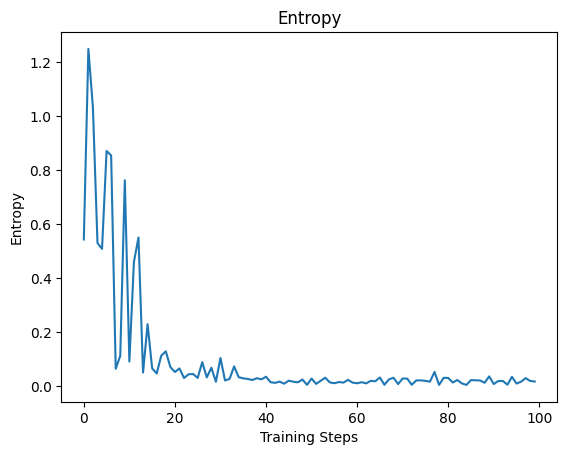

In [ ]:
training_loss_logger = []
entropy_logger = []

for epoch in tqdm(range(50)):
    # Set LSTM generator model to training mode
    lstm_generator.train()
    steps = 0
    # Iterate over batches in training data loader
    for text in tqdm(data_loader_train, desc="Training", leave=False):
        # Transform text tokens using training transform and move to device
        bs = text.shape[0]
        
        # Randomly drop input tokens
        # input_text = td(text_tokens[:, 0:-1])
        # output_text = text_tokens[:, 1:]
        input_text = text[:, 0:-1]
        output_text = text[:, 1:]
        
        # Initialize the memory buffers
        hidden = torch.zeros(num_layers, bs, hidden_size)
        memory = torch.zeros(num_layers, bs, hidden_size)
        
        # Forward pass through the LSTM generator
        pred, hidden, memory = lstm_generator(input_text, hidden, memory)

        # Calculate loss
        loss = loss_fn(pred.transpose(1, 2), output_text)
        
        # Zero gradients, perform backward pass, and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Log training loss
        training_loss_logger.append(loss.item())
        
        # Log entropy during training (for monitoring)
        with torch.no_grad():
            dist = Categorical(logits=pred)
            entropy_logger.append(dist.entropy().mean().item())
            
# Display training loss and entropy
plt.plot(training_loss_logger)
plt.xlabel('Training Steps')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Loss')
plt.show()

plt.plot(entropy_logger)
plt.xlabel('Training Steps')
plt.ylabel('Entropy')
plt.title('Entropy')
plt.show()

In [ ]:
# init data
print(inter_test)
data_set_test = CustomDataSetRNN(actions=actions, outcomes=outcomes,
                    context_lenght=15, dim_out=2, tokenizer=tokenizer)


In [ ]:
# find pattern
find_sub_list()

In [ ]:
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)

print(input)
print(target)



Inspired by https://github.com/LukeDitria/pytorch_tutorials.git

In [ ]:
see_evolued_acc(training_acc_logger)
see_evolued_acc(test_acc_logger)

see_evolued_loss([training_loss_logger])
see_evolued_loss([test_loss_logger])

In [ ]:
print(training_loss_logger)